In [1]:
#here we rerun the genotype calling including a) the depth channels which required a more supervised approach b) the ATACseq channels.
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
library(GenotypeMixtures)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
#get the sequencing inventory and make a multiplexing matrix  - write out the relevant files ####
tenx_dir <- "./data/seq_data/10X_3p"
sequencing_inventory <- read.csv("/nfs/team297/bs16/sample_donor_data/sequencing_inventory.csv", check.names = FALSE)
sequencing_inventory <- sequencing_inventory[
    sequencing_inventory$experiment %in% c("10X_3'_V3") & 
                                           sequencing_inventory$cellranger_SOC %in% 'TRUE' & 
                                             sequencing_inventory$poor_QC %in% "FALSE",]
#exclude fetal - these are one per channel and we will analyse these elsewhere
sequencing_inventory <- sequencing_inventory[!sequencing_inventory$tissue %in% grep("fetal", sequencing_inventory$tissue, value = TRUE), ]
#remove perfusion samples
perfusion_batches = c("Batch_9", "Batch_12", "Batch_14")
sequencing_inventory = sequencing_inventory[!sequencing_inventory$tissue_dissociation_processing_batch %in% perfusion_batches, ]
#fix the irods spaces
sequencing_inventory$irods_ID <- gsub(" ", "", sequencing_inventory$irods_ID)
table(sequencing_inventory$tissue)
#copy
multiplex_design = sequencing_inventory


         Glomerulus_single_cell_suspension 
                                        20 
             kidney_single_cell_suspension 
                                         6 
               lung_single_cell_suspension 
                                         1 
lymph_node_lymphoid_single_cell_suspension 
                                         1 
 lymph_node_myeloid_single_cell_suspension 
                                         1 
         lymph_node_single_cell_suspension 
                                         1 
               PBMC_single_cell_suspension 
                                         1 
    spleen_lymphoid_single_cell_suspension 
                                         3 
     spleen_myeloid_single_cell_suspension 
                                         3 
     TI_compartment_single_cell_suspension 
                                        11 

In [3]:
#get channels
channels <- multiplex_design$sanger_ID
#get the correct directory 
seq_dir = multiplex_design$`10xDIR`
#reset some of the directory names names
seq_dir[seq_dir == '10x3p'] = '10X_3p'
seq_dir[seq_dir == '10xATAC'] = '10X_snATACseq'
seq_dir[seq_dir == '10x_multiome'] = '10X_multiome'
#then build a multiplexing matrix
channel_donors <- strsplit(multiplex_design$donor, "_")
names(channel_donors) <- multiplex_design$sanger_ID
donors <- unique(unlist(channel_donors))
multiplexing_mat <- do.call(rbind, lapply(names(channel_donors), function(i){
  donors %in% channel_donors[[i]]*1
}))
colnames(multiplexing_mat) <- donors
rownames(multiplexing_mat) <- names(channel_donors)

In [4]:
#get the locations of the files ####
dirs <- multiplex_design[match(multiplex_design$sanger_ID, rownames(multiplexing_mat)), "10xDIR"]
locations <- data.frame("channel" = rownames(multiplexing_mat), 
                        "SOC_location" = file.path("/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data", seq_dir, multiplex_design$irods_ID, "SOC_common_variants"))

Using channel as id variables



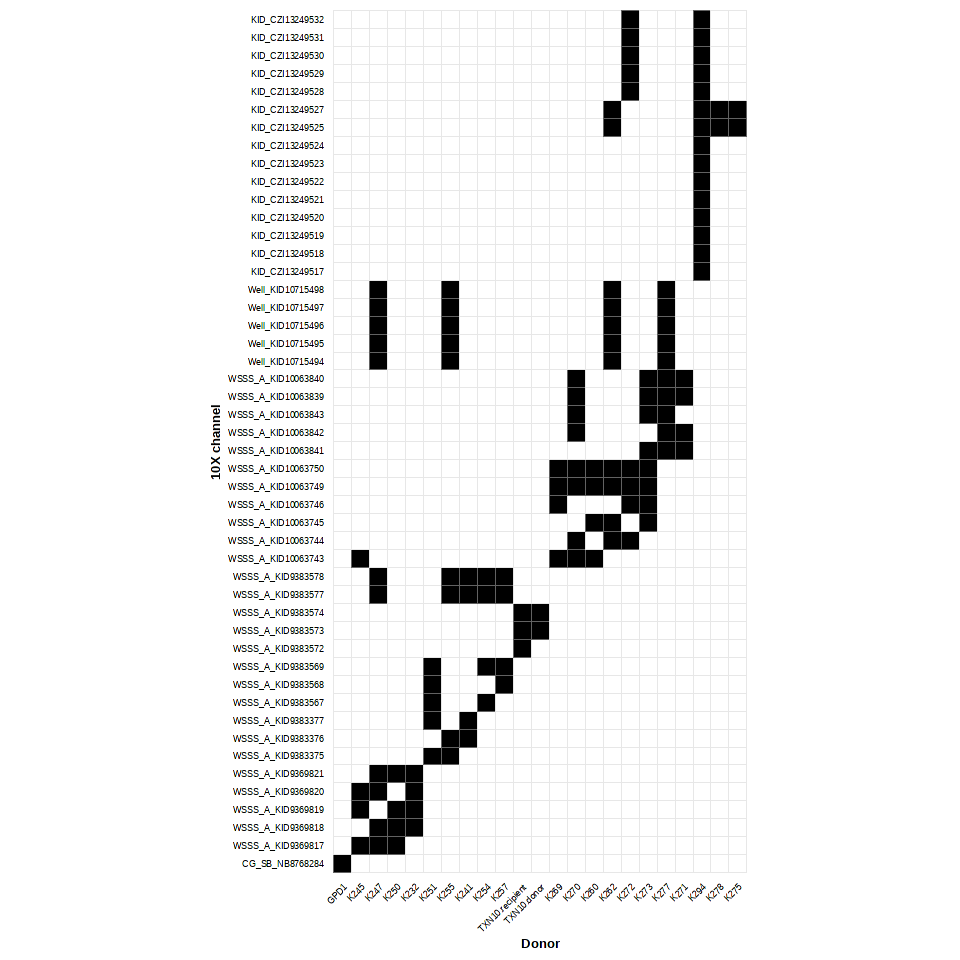

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_experimental_design(multiplexing_mat)

In [6]:
genotype_clustering_output <- construct_genotype_cluster_graph(experimental_design = multiplexing_mat, 
                                                               file_locations = locations, ncounts  = 5, use_VAF = TRUE)

checking files



  |                                                                      |   0%

reading in VCF files


   *****       ***   vcfR   ***       *****
   This is vcfR 1.13.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




  |======================================================================| 100%


the membership graph is a collection of complete subgraphs as expected



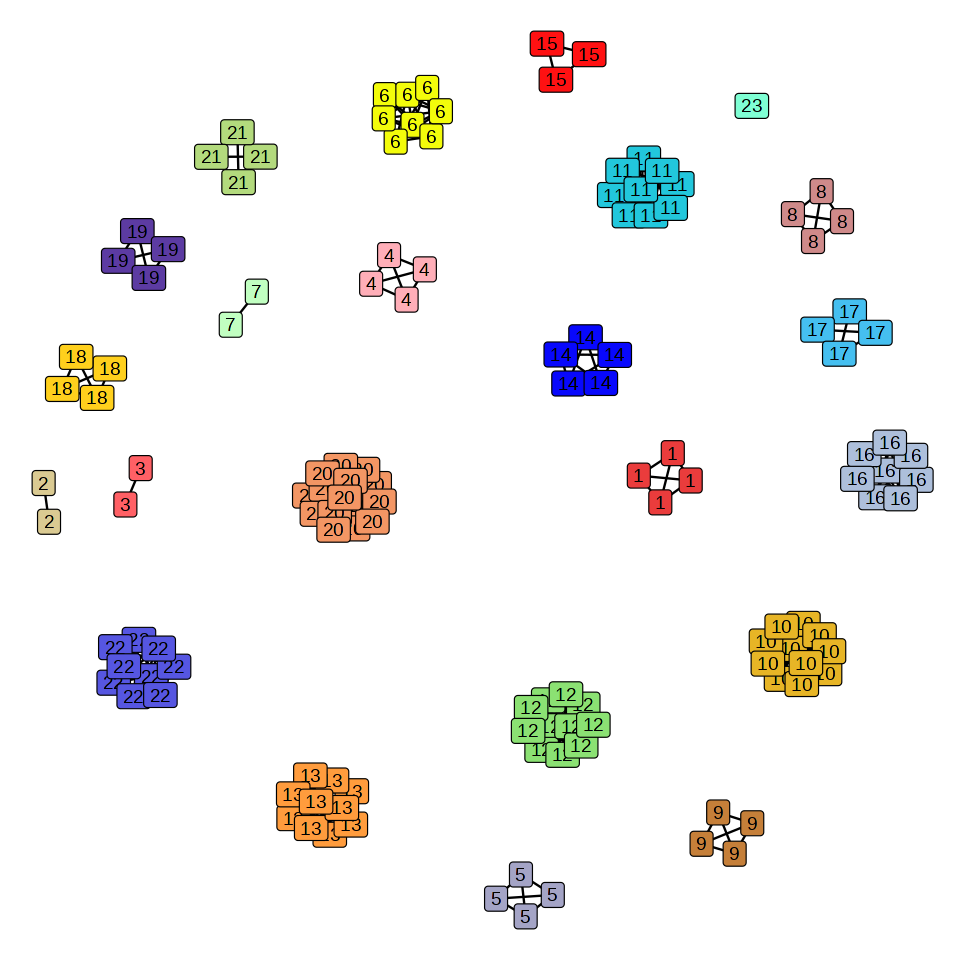

In [7]:
genotype_clustering_output$graph_plot

In [8]:
#write read the clustering                                                               
saveRDS(genotype_clustering_output, "data/genotypes/genotype_clustering_output_cells.RDS")
genotype_clustering_output <- readRDS("data/genotypes/genotype_clustering_output_cells.RDS")

In [9]:
sex_expression = do.call(rbind, lapply(unique(genotype_clustering_output$graph_membership), function(x){
#get the clusters that are in this membership group
clusters = names(genotype_clustering_output$graph_membership[genotype_clustering_output$graph_membership %in% x])
split = strsplit(clusters, "_")
cl = unlist(lapply(split, function(x){x[length(x)]}))
channels = unlist(lapply(1:length(strsplit(clusters, "_")), function(x){
    x_s = split[[x]]
    cl = paste0("_", x_s[length(x_s)])
    return(gsub(cl, "", clusters[x]))
}))
df = data.frame("cluster" = cl, "channel" = channels)
#this spills out a dataframe of clusters and channels
#get the first channel
channel = df$channel[1]
#get the first cluster
cl = df$cluster[1]
#get the irods ID
irods_id = sequencing_inventory[sequencing_inventory$sanger_ID %in% channel, "irods_ID" ]
#get the locations for the files
dir = locations[locations$channel %in% channel, 2]
h5dir = gsub("/SOC_common_variants", "", locations[locations$channel %in% channel, 2])
fp = file.path(h5dir, "scAR_denoised.h5ad") #use the denoised expression values
#read in the data
adata = sc$read_h5ad(fp)
#isolate the cells in this cluster
clusters = read.csv(file.path(dir, "clusters.tsv"), sep = "\t")
rownames(clusters) = paste0(clusters$barcode, "_", irods_id)
cells = rownames(clusters[clusters$assignment %in% cl, ])
adata = adata[adata$obs_names$values %in% cells]
sc$pp$normalize_total(adata) #normalize
sc$pp$log1p(adata) #log transform
#define the average XIST expression
XIST_expr = mean(adata$X[, adata$var_names$values %in% "XIST"])
RPS4Y1_expr = mean(adata$X[, adata$var_names$values %in% "RPS4Y1"])
rm(adata)
out  = data.frame("graph_membership" = x, "XIST_expr" = XIST_expr, "RPS4Y1_expr" = RPS4Y1_expr)
return(out)}))

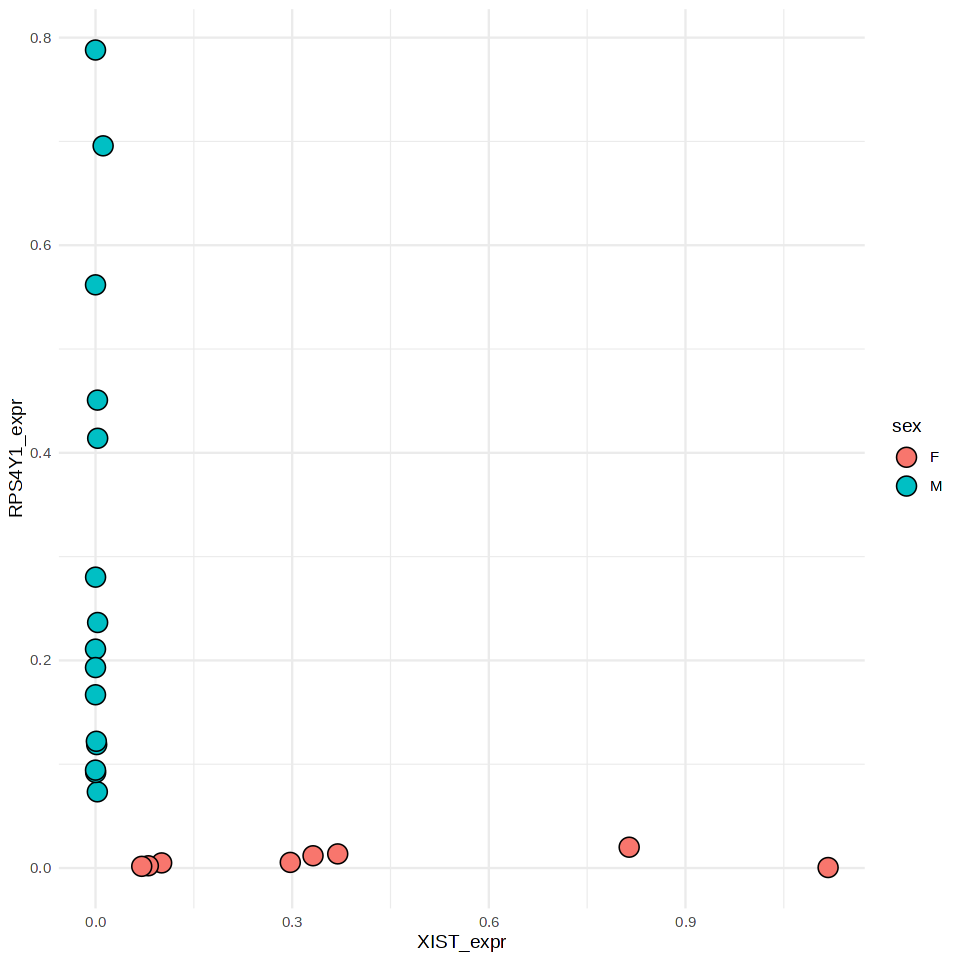

In [10]:
sex_expression$sex = factor(ifelse(sex_expression$RPS4Y1_expr > sex_expression$XIST_expr, "M", "F"))
rownames(sex_expression) = sex_expression$graph_membership
ggplot(sex_expression, aes(x = XIST_expr, y = RPS4Y1_expr, fill = sex)) + geom_point(pch =21, size = 5) + 
theme_minimal()

In [11]:
#map clusters to samples ####
cluster_mapping <- membership_map(experimental_design = multiplexing_mat,
                                  graph_output =  genotype_clustering_output)
cluster_mapping$sample <- sequencing_inventory[match(cluster_mapping$channel, sequencing_inventory$sanger_ID), "irods_ID"]
cluster_mapping$sex = sex_expression[cluster_mapping$genotype_cluster, 'sex']

In [12]:
#get donor demographic data
donor_demographics = read.csv("~/nfs/team297/bs16/sample_donor_data/donor_demographics.csv", row.names = 1)
cluster_mapping$known_sex =  donor_demographics[cluster_mapping$genotype, 'donor_sex']
cluster_mapping = cluster_mapping[cluster_mapping$known_sex == cluster_mapping$sex, ] #remove the ambiguous matches where two donor have identical overlap patterns but different sexes.

In [13]:
saveRDS(cluster_mapping, "data/genotypes/cluster_mapping_cells.RDS")

In [14]:
cell_assignments <- cells_to_genotypes(SOC_locations = locations, 
                                       membership_mat =cluster_mapping)
saveRDS(cell_assignments, "data/genotypes/cell_assignments_cells.RDS")

In [15]:
write.csv(cell_assignments,
          "data/genotypes/cell_assignments_cells.csv", 
         row.names = FALSE)

In [16]:
#get ambients
ambient <- suppressWarnings(unlist(lapply(locations$SOC_location, function(x){
  amb <- read.table(file.path(x, 'ambient_rna.txt'), check.names = FALSE)
  amb <- amb[, 5]
  amb <- as.numeric(gsub("%", "", amb))/100
  return(amb)})))
names(ambient) <- locations$channel
saveRDS(ambient, "data/genotypes/ambient_proportions_cells.RDS")

In [17]:
ambient

CG_SB_NB8768284  WSSS_A_KID9369817  WSSS_A_KID9369818  WSSS_A_KID9369819 
       0.995768389        0.035272109        0.040047382        0.035720432 
 WSSS_A_KID9369820  WSSS_A_KID9369821  WSSS_A_KID9383375  WSSS_A_KID9383376 
       0.032270313        0.041578206        0.031195999        0.029069181 
 WSSS_A_KID9383377  WSSS_A_KID9383567  WSSS_A_KID9383568  WSSS_A_KID9383569 
       0.025624140        0.019417970        0.020591975        0.010747078 
 WSSS_A_KID9383572  WSSS_A_KID9383573  WSSS_A_KID9383574  WSSS_A_KID9383577 
       0.995327663        0.023276326        0.070123344        0.028834958 
 WSSS_A_KID9383578 WSSS_A_KID10063743 WSSS_A_KID10063744 WSSS_A_KID10063745 
       0.021922033        0.015331678        0.016453795        0.015329035 
WSSS_A_KID10063746 WSSS_A_KID10063749 WSSS_A_KID10063750 WSSS_A_KID10063841 
       0.030868850        0.014418479        0.012899681        0.050752108 
WSSS_A_KID10063842 WSSS_A_KID10063843 WSSS_A_KID10063839 WSSS_A_KID10063840 
       0.064503113        0.053123343        0.028033357        0.027848294 
  Well_KID10715494   Well_KID10715495   Well_KID10715496   Well_KID10715497 
       0.024559292        0.033029730        0.019615502        0.018505313 
  Well_KID10715498    KID_CZI13249517    KID_CZI13249518    KID_CZI13249519 
       0.009579084        0.997687711        0.976062333        0.995496251 
   KID_CZI13249520    KID_CZI13249521    KID_CZI13249522    KID_CZI13249523 
       0.982634399        0.997485392        0.997330209        0.997044268 
   KID_CZI13249524    KID_CZI13249525    KID_CZI13249527    KID_CZI13249528 
       0.997345370        0.031971429        0.042150862        0.021147018 
   KID_CZI13249529    KID_CZI13249530    KID_CZI13249531    KID_CZI13249532 
       0.023378366        0.024231839        0.040501512        0.033741087

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


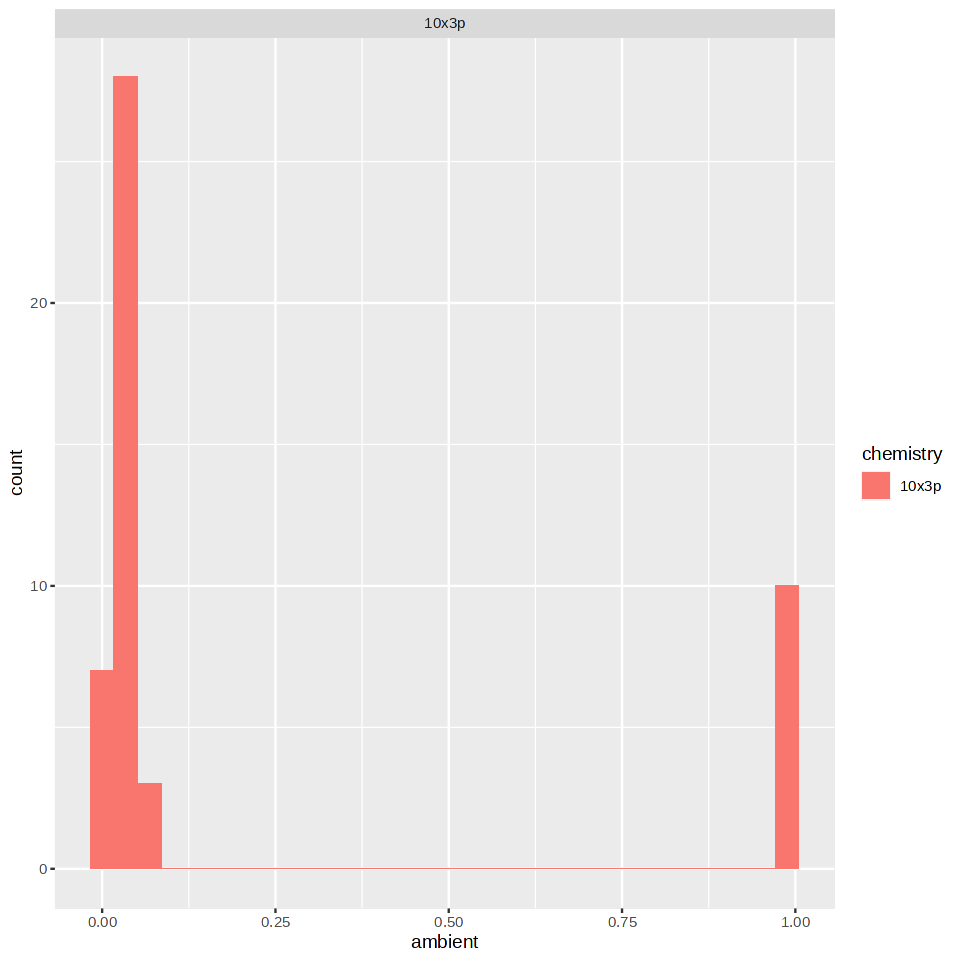

In [18]:
ggplot(data.frame('ambient' = ambient, "chemistry" = sequencing_inventory$'10xDIR'), aes(x=ambient)) + 
geom_histogram(aes(fill = chemistry)) + facet_wrap(~chemistry, scales = 'free_y')

In [19]:
table(cell_assignments$genotype[cell_assignments$status == 'singlet'])


           GPD1            K232            K241            K245            K247 
           2468           10288            8230            8042           23369 
           K250            K251            K254            K255            K257 
          16717           19319            9818           12335            5936 
           K260            K262            K269            K270            K271 
           1986            6597            8454           19451           17305 
           K272            K273            K275            K277            K278 
          20936           13708            4792           22314            1343 
           K294     TXN10-donor TXN10-recipient 
          73952            4432           19465 